In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import helper
from helper import *

In [2]:
df = feature_engineer(load_and_preprocess())
df.head()

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


Description   Humidity  Wind Direction  Temperature  \
datetime                                                                    
2012-10-02 19:00:00  sky is clear  71.861538     1016.424953       288.94   
2012-10-02 20:00:00  sky is clear  71.861538     1016.424953       288.69   
2012-10-02 21:00:00  heavy clouds  77.000000     1007.000000       288.55   
2012-10-02 22:00:00  sky is clear  71.861538     1016.424953       288.22   
2012-10-02 23:00:00  sky is clear  71.861538     1016.424953       287.92   

                     Pressure  Wind Speed  clouds  rain  mist  snow  ...  \
datetime                                                             ...   
2012-10-02 19:00:00     282.0         2.0       0     0     0     0  ...   
2012-10-02 20:00:00     239.0         5.0       0     0     0     0  ...   
2012-10-02 21:00:00     260.0         7.0       1     0     0     0  ...   
2012-10-02 22:00:00     284.0         0.0       0     0     0     0  ...   
2012-10-02 23:00:00     267.0         0.0       0     0     0     0  ...   

                     rolling_min_temp  rolling_min_pressure  \
datetime                                                      
2012-10-02 19:00:00               NaN                   NaN   
2012-10-02 20:00:00            288.69                 239.0   
2012-10-02 21:00:00            288.55                 239.0   
2012-10-02 22:00:00            288.22                 239.0   
2012-10-02 23:00:00            287.92                 239.0   

                     rolling_min_wind_dir  rolling_min_wind_speed  \
datetime                                                            
2012-10-02 19:00:00                   NaN                     NaN   
2012-10-02 20:00:00           1016.424953                     2.0   
2012-10-02 21:00:00           1007.000000                     2.0   
2012-10-02 22:00:00           1007.000000                     0.0   
2012-10-02 23:00:00           1007.000000                     0.0   

                     rolling_min_humidity  rolling_max_temp  \
datetime                                                      
2012-10-02 19:00:00                   NaN               NaN   
2012-10-02 20:00:00             71.861538            288.94   
2012-10-02 21:00:00             71.861538            288.94   
2012-10-02 22:00:00             71.861538            288.94   
2012-10-02 23:00:00             71.861538            288.94   

                     rolling_max_pressure  rolling_max_wind_dir  \
datetime                                                          
2012-10-02 19:00:00                   NaN                   NaN   
2012-10-02 20:00:00                 282.0           1016.424953   
2012-10-02 21:00:00                 282.0           1016.424953   
2012-10-02 22:00:00                 284.0           1016.424953   
2012-10-02 23:00:00                 284.0           1016.424953   

                     rolling_max_wind_speed  rolling_max_humidity  
datetime                                                           
2012-10-02 19:00:00                     NaN                   NaN  
2012-10-02 20:00:00                     5.0             71.861538  
2012-10-02 21:00:00                     7.0             77.000000  
2012-10-02 22:00:00                     7.0             77.000000  
2012-10-02 23:00:00                     7.0             77.000000  

[5 rows x 76 columns]

In [3]:
df = df.dropna()

In [25]:
df2 = df[['Temperature']].reset_index().rename(columns = {'datetime': 'Date'})

In [26]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df2['Date'], y=df2['Temperature'], name='Temperature (Kelvin)'))
fig.update_layout(showlegend=True)
fig.show()

In [27]:
train, test = df2.loc[df2['Date'] <= '2016-01-01'], df2.loc[df2['Date'] > '2016-01-01']
train.shape, test.shape

((28278, 2), (16776, 2))

In [29]:
sc = StandardScaler()
train['Temperature'] = sc.fit_transform(train[['Temperature']])
test['Temperature'] = sc.transform(test[['Temperature']])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
train

Date  Temperature
0     2012-10-09 19:00:00     0.424899
1     2012-10-09 20:00:00     0.474778
2     2012-10-09 21:00:00     0.488679
3     2012-10-09 22:00:00     0.430623
4     2012-10-09 23:00:00     0.159965
...                   ...          ...
28273 2015-12-31 20:00:00    -0.557156
28274 2015-12-31 21:00:00    -0.563016
28275 2015-12-31 22:00:00    -0.593953
28276 2015-12-31 23:00:00    -0.600838
28277 2016-01-01 00:00:00    -0.609489

[28278 rows x 2 columns]

In [33]:
def create_sequences(X, y, time_steps = 24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [35]:
X_train, y_train = create_sequences(train[['Temperature']], train[['Temperature']], 24)
X_test, y_test = create_sequences(test[['Temperature']], test[['Temperature']], 24)

In [37]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(32, input_shape = X_train.shape[1:]))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(X_train.shape[1]))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(X_train.shape[2])))

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 24, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 32)            8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 32)            0         
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 1)             33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
__________________________________________________

In [39]:
history = model.fit(X_train, y_train, epochs = 100, validation_split=0.1, batch_size = 32, callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
795/795 [==============================] - 11s 11ms/step - loss: 0.2157 - val_loss: 0.1220
Epoch 2/100
795/795 [==============================] - 8s 10ms/step - loss: 0.1249 - val_loss: 0.0865
Epoch 3/100
795/795 [==============================] - 8s 10ms/step - loss: 0.1113 - val_loss: 0.0753
Epoch 4/100
795/795 [==============================] - 8s 10ms/step - loss: 0.1063 - val_loss: 0.0696
Epoch 5/100
795/795 [==============================] - 8s 10ms/step - loss: 0.1055 - val_loss: 0.0684
Epoch 6/100
795/795 [==============================] - 8s 10ms/step - loss: 0.1057 - val_loss: 0.0703
Epoch 7/100
795/795 [==============================] - 8s 10ms/step - loss: 0.1041 - val_loss: 0.0683
Epoch 8/100
795/795 [==============================] - 8s 10ms/step - loss: 0.1028 - val_loss: 0.0799
Epoch 9/100
795/795 [==============================] - 8s 10ms/step - loss: 0.1036 - val_loss: 0.0763
Epoch 10/100
795/795 [==============================] - 8s 10ms/step - loss: 0.10

In [41]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis = 1)

<AxesSubplot:ylabel='Count'>

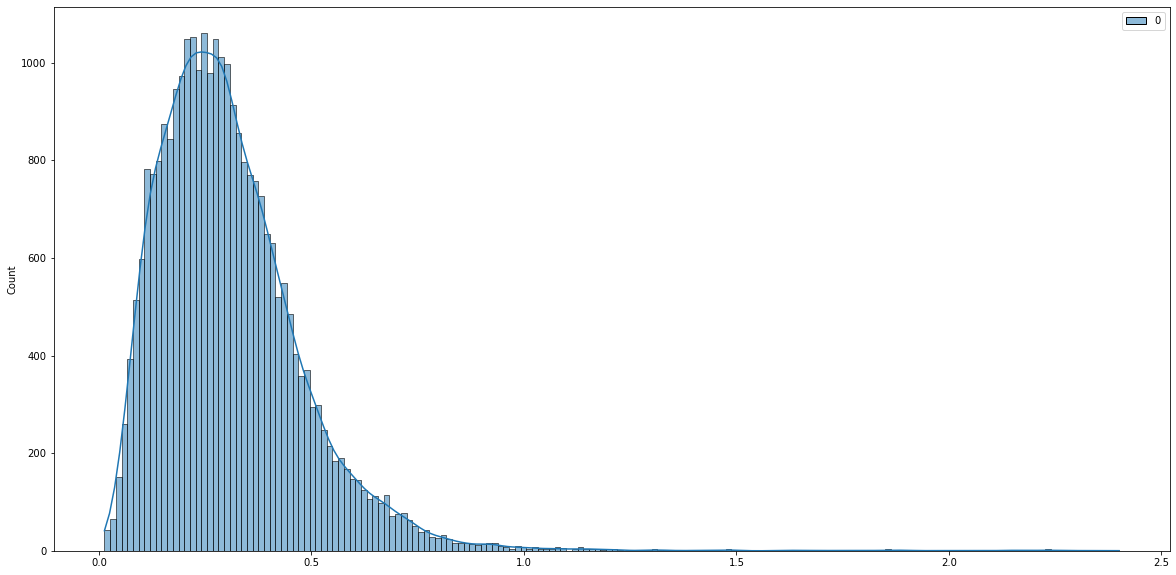

In [44]:
plt.figure(figsize=(20, 10))
sns.histplot(train_mae_loss, kde=True)

<AxesSubplot:ylabel='Count'>

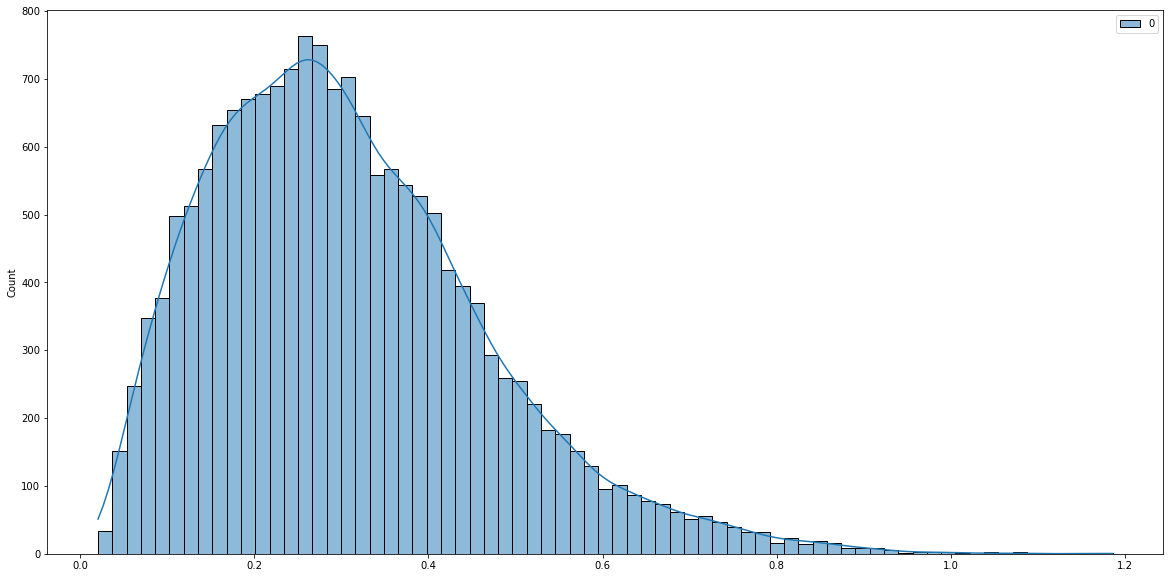

In [46]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)

plt.figure(figsize=(20,10))
sns.histplot(test_mae_loss, kde=True)

In [71]:
threshold = np.quantile(train_mae_loss, 0.995)

test_score_df = pd.DataFrame(test[24:])
test_score_df['loss'] = test_mae_loss
test_score_df['anomaly'] = np.where(test_mae_loss>threshold, True, False)
test_score_df['threshold'] = threshold
test_score_df.head()

Date  Temperature      loss  anomaly  threshold
28302 2016-01-02 01:00:00    -0.642197  0.104669    False   0.974141
28303 2016-01-02 02:00:00    -0.695599  0.098839    False   0.974141
28304 2016-01-02 03:00:00    -0.660186  0.079317    False   0.974141
28305 2016-01-02 04:00:00    -0.667158  0.095712    False   0.974141
28306 2016-01-02 05:00:00    -0.696983  0.098026    False   0.974141

In [72]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name = 'Test MAE'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [73]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(12, 5)

In [77]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=sc.inverse_transform(test_score_df['Temperature']) - 273.15, name = 'Temperature'))
fig.add_trace(go.Scatter(x = anomalies['Date'], y=sc.inverse_transform(anomalies['Temperature']) - 273.15, name = 'Anomaly', mode = 'markers'))
fig.update_layout(showlegend=True, title='Detected Anomalies')
fig.show()